In [1]:
import os
from sound.sound_eval import eval_sound
import numpy as np
from matplotlib import pyplot as plt
import pydub
from time_series.anomaly_detection import polyreg_outliar_mse, lof
from time_series.smoothening_functions import power_smooth, llr_smooth, ewma_bias_corrected, kaiser_wind,derivative

In [2]:
def eval_linreg(arr, n, linreg):
    arr = np.array(arr).reshape((len(arr),))
    windows = []
    labels = []
    for i in range(len(arr)-n):
        windows.append(arr[i:i+n])
        labels.append(arr[i+n])
    return (linreg.predict(windows) - labels)**2

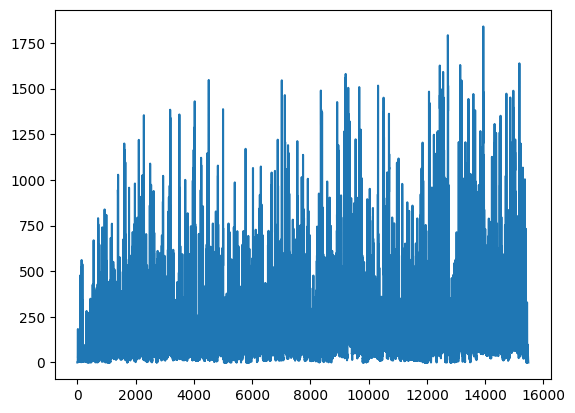

In [3]:
a = pydub.AudioSegment.from_mp3("data/custom_3.mp3")
        
y = np.array(a.get_array_of_samples())
data_binr, data_rmsr, _ = eval_sound(y,a)
plt.plot(data_binr)
plt.show()

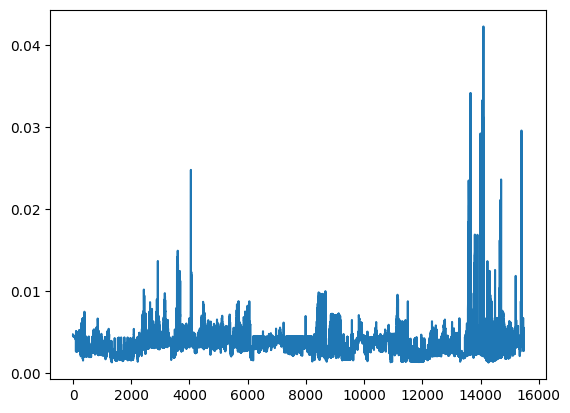

In [4]:
singl_frm = np.loadtxt("data/arr.csv", delimiter = ",")
plt.plot(singl_frm)
plt.show()

In [5]:
def get_anomls(arr, signal, thr):
    segms = []
    
    
    print(thr)
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            i+=1
            continue
        start = i
        while i < len(arr) and arr[i]==1:
            i+=1
        
        
        
        segms.append([start, np.max(np.array(signal[i-180:i+180])), i])
        i+=1
    return segms

15480


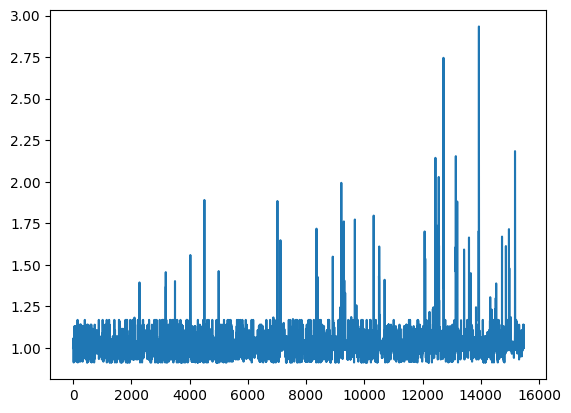

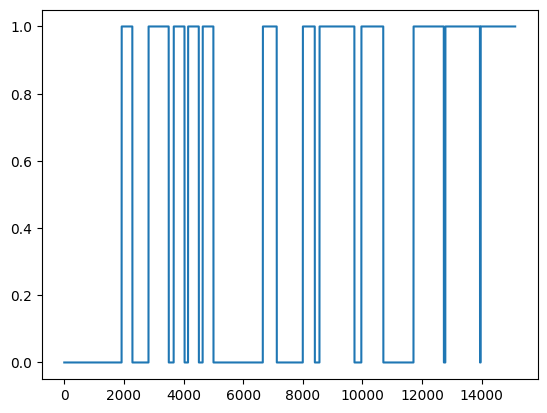

15121
0.5
12
5.341666666666667 6.341666666666667 1.3940171993656416
7.847222222222222 9.727777777777778 1.4019822113739655
10.191666666666666 11.2 1.5589648006752026
11.530555555555555 12.530555555555555 1.8901701849367905
12.891666666666667 13.891666666666667 1.4622865403767178
18.494444444444444 19.788888888888888 1.88398475709658
22.219444444444445 23.333333333333332 1.7176252166912553
23.772222222222222 27.025 1.7726599961984
27.67222222222222 29.71388888888889 1.410052372055667
32.53055555555556 35.352777777777774 2.7455320377940065
35.49444444444445 38.71944444444444 2.934097005341174
38.78333333333333 42.00277777777778 2.1839780073467856
5.341666666666667 6.341666666666667 1.3940171993656416
7.847222222222222 9.727777777777778 1.4019822113739655
27.67222222222222 29.71388888888889 1.410052372055667
12.891666666666667 13.891666666666667 1.4622865403767178
10.191666666666666 11.2 1.5589648006752026
22.219444444444445 23.333333333333332 1.7176252166912553
23.772222222222222 27.025 

In [6]:
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
print(len(data_binr))
interm = np.array(data_binr)
r = 360
interm  = lof(interm, r )
signal  = interm

plt.plot(interm)
plt.show()
interm = interm > 1.25 + 0
interm  = power_smooth(interm, r )
interm[interm>1] = 1
plt.plot(interm)
plt.show()
print(len(interm))
segms = get_anomls(interm, signal, 0.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    # s[0]-=r/2
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])

15490


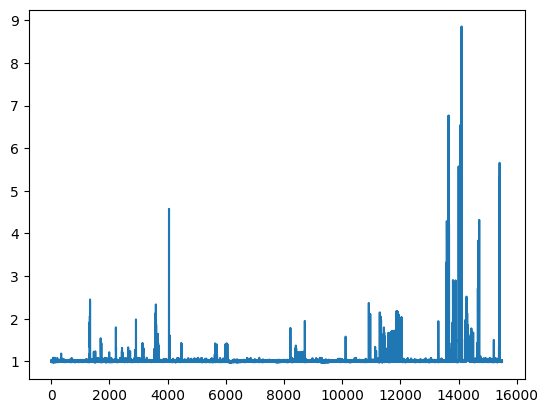

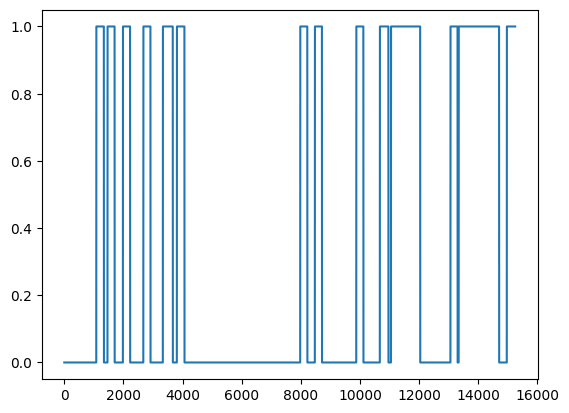

0.5
15251
14
2.675 3.7194444444444446 2.4494973463238483
3.727777777777778 4.727777777777778 1.5406504851855185
5.175 6.183333333333334 1.7963715836082566
7.094444444444444 8.097222222222221 1.982475087369816
8.927777777777777 10.194444444444445 2.334703482275453
10.244444444444444 11.28888888888889 4.576386279954255
21.833333333333332 22.833333333333332 1.7824710420602126
23.208333333333332 24.208333333333332 1.9470470655221888
27.1 28.1 1.5784834182351157
29.31388888888889 30.45 2.368838482736443
30.358333333333334 33.43611111111111 2.178390600831244
35.94722222222222 36.94722222222222 1.9417281898907972
36.71944444444444 40.85 4.318739200671734
41.24166666666667 42.36388888888889 5.656599239925289
3.727777777777778 4.727777777777778 1.5406504851855185
27.1 28.1 1.5784834182351157
21.833333333333332 22.833333333333332 1.7824710420602126
5.175 6.183333333333334 1.7963715836082566
35.94722222222222 36.94722222222222 1.9417281898907972
23.208333333333332 24.208333333333332 1.94704706552

In [15]:
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
print(len(singl_frm))
interm = np.array(singl_frm)
r = 240
interm  = lof(interm, r )
signal  = interm

plt.plot(interm)
plt.show()
interm = interm > 1.5 + 0
interm  = power_smooth(interm, r )
interm[interm>1] = 1
plt.plot(interm)
plt.show()
segms = get_anomls(interm, signal, 0.5)
print(len(interm))
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    s[0]-=r/2
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])

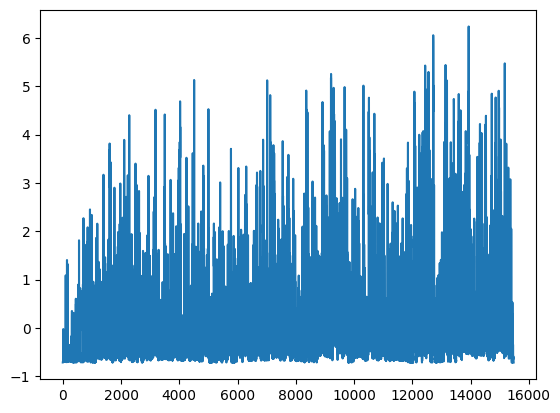

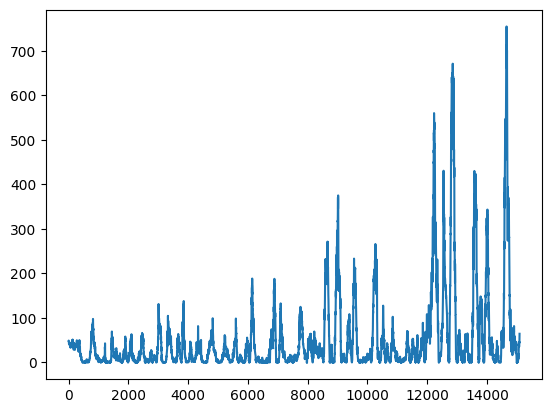

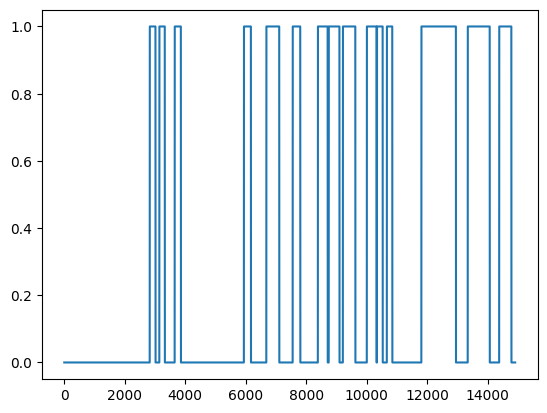

0.5
15
8.933333333333334 9.46111111111111 1.982475087369816
9.816666666666666 10.316666666666666 1.4135499207756184
11.225 11.794444444444444 1.380038075572781
17.583333333333332 18.227777777777778 1.4237277479645767
19.644444444444446 20.830555555555556 1.0825553103848733
22.06388888888889 22.761111111111113 1.0362229525266726
24.377777777777776 25.27777777777778 1.9470470655221888
25.375 26.36111111111111 1.0834565886354304
26.675 27.819444444444443 1.0370333896334458
28.875 29.761111111111113 1.080859877276209
29.805555555555557 30.330555555555556 1.080859877276209
30.71388888888889 31.21388888888889 2.368838482736443
33.88611111111111 37.05833333333333 1.0821012581197058
38.144444444444446 40.16388888888889 8.856489490640033
41.03333333333333 42.15277777777778 4.318739200671734
22.06388888888889 22.761111111111113 1.0362229525266726
26.675 27.819444444444443 1.0370333896334458
28.875 29.761111111111113 1.080859877276209
29.805555555555557 30.330555555555556 1.080859877276209
33.886

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
r = 180
d_interm = sc.fit_transform(X  =np.array(data_binr).reshape(-1,1), y = None)
# d_interm = np.log(np.array(data_binr))
# d_interm = data_binr
plt.plot(d_interm)
plt.show()
unsup_linreg = polyreg_outliar_mse([d_interm.reshape(-1,)],r)
interm = eval_linreg(kaiser_wind(d_interm.reshape(-1,), r+30, 2), r, unsup_linreg)
plt.plot(interm)
plt.show()
interm = interm >  100 + 0
interm  = power_smooth(interm, 180 )
interm[interm>1] = 1
plt.plot(interm)
plt.show()
segms = get_anomls(interm, signal, 0.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    # s[0]-=r/2
    s[0]+=r*2+30
    s[-1]+=r*2+30
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])